# Captcha Solving
In fulfillment of ENITS Data Mining M+I803, WS 24/25

https://www.kaggle.com/code/avhsog4444/m-i803-avhsogws24-25/notebook

In [15]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import img_to_array
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import imageio.v3 as imageio

## Image Loading and Preprocessing
**Image Loading (cv2.imread):**
  - Reads the image in grayscale mode.
  - Grayscale reduces data complexity while preserving key structural details (e.g., edges and contrasts).

**Adaptive Thresholding:**
  ```
  image = cv2.adaptiveThreshold(
      image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 2
  )
  ```
Maximum value (255) Sets the binary value for pixels above the threshold.

**Method (ADAPTIVE_THRESH_GAUSSIAN_C)**
Uses a Gaussian-weighted sum for local thresholding.

**Block Size (145)**
Defines the neighborhood size for threshold calculation. A larger block size captures more global trends; a smaller one is more local.

**Constant (2)**
Subtracts from the computed mean. Tweaking this value adjusts how aggressive the thresholding is.

Variations
Changing block size or constant can help with images having different lighting or background noise.

## Morphological Closing
```
close_kernel = np.ones((3, 3), np.uint8)
image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, close_kernel)
```
Uses a 3x3 kernel to fill small holes or gaps in the binary image.
A larger kernel (e.g., 5x5) might fill larger gaps but could also over-smooth details.

## Dilation

```
dilate_kernel = np.ones((2, 2), np.uint8)
image = cv2.dilate(image, dilate_kernel, iterations=2)
```
Expands the white regions (characters) to better connect broken parts.
Iterations (2): Controls how many times the dilation is applied. More iterations increase the expansion.
Changing the kernel size or number of iterations can fine-tune the connection of character components.

## Gaussian Blur

```
image = cv2.GaussianBlur(image, (5, 5), 0)
```

Smooths the image by averaging pixel values using a Gaussian function.
## Kernel Size (5x5)
Determines the level of smoothing.

Variation: Adjust the kernel size or sigma for different levels of noise reduction.

## Image Inversion

```
image = cv2.bitwise_not(image)
```
Inverts the binary image so that characters become white on a black background (or vice versa), which can be more suitable for some segmentation/classification pipelines.

Alternative approaches were considered, such as splitting the image dynamically by calculating the image dimensions and dividing the width into equal parts:
```
n_chars = 5
height, width = image.shape
start_row = int(height * 0.5)  # Intended to use a central band of the image
end_row = int(height * 0.5)
char_width = width // n_chars
char_segments = [ image[start_row:end_row, i*char_width:(i+1)*char_width] for i in range(n_chars) ]
```

However, this approach did not yield the expected segmentation because it did not correctly define the vertical bounds. More tweaking is needed here.

Other variations with slightly shifted boundaries or overlapping segments were also considered (as seen in the commented-out code). These adjustments help refine the segmentation when characters are spaced unevenly or if there is a risk of cutting off parts of characters.

# Automated Segmentation Possibilities
While the code currently uses fixed segmentation coordinates based on empirical observations, an automated segmentation approach could improve robustness. Some possibilities include:

## Adaptive Pixel Clustering
Techniques such as connected-components analysis or contour detection can automatically group pixels into regions corresponding to individual characters. This method would adapt to variations in character positioning and size.

## Dynamic Boundary Calculation
Instead of relying on hard-coded indices, boundaries could be calculated based on the distribution of pixel intensities or edges. For example, using projection profiles or analyzing horizontal/vertical pixel density can help determine where characters start and end.

## Deep Learning Based Segmentation
More advanced methods involve training a segmentation network (e.g., U-Net) to directly segment out characters from captcha images. This could be especially useful when captcha images vary widely in layout and noise patterns.

## Label Extraction and Data Preparation
After segmentation, the code extracts the label for each character from the filename (using slicing such as filename[-9:-4]). Each valid segment is converted into an array using img_to_array, and both the image data (X) and labels (y) are appended. The images are later normalized to the range [0, 1]. Labels are encoded using LabelEncoder followed by one-hot encoding with OneHotEncoder.

Finally, the dataset is split into training and testing sets using train_test_split with:

- `test_size=0.4`: 40% of the data is reserved for testing.
- `random_state=420`: Ensures reproducibility.
- `stratify=y_onehot`: Maintains the same class distribution in both training and testing sets.

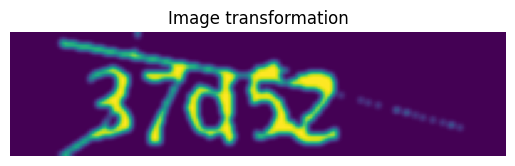

Processed 5350 segments.
Shape of X: (5350, 40, 20, 1)
Shape of y: (5350,)


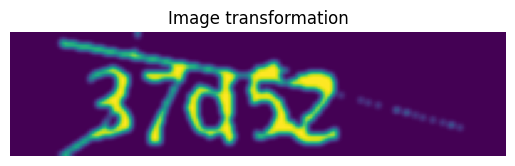

In [16]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import img_to_array
from PIL import Image
import imageio.v3 as imageio

# Initialize data arrays
X = []
y = []

# Kernel definitions for morphological operations
# I changed initial measure of close kernel from 5x5 to 3x3
close_kernel = np.ones((3, 3), np.uint8)
dilate_kernel = np.ones((2, 2), np.uint8)

# Process images from directory
for dirname, _, filenames in os.walk('/kaggle/input/data84u8rhfnd921ndksao02318uhen'):
    for filename in filenames:
        if filename.endswith(('.png', '.jpg', '.jpeg')):  # Process only image files
            path = os.path.join(dirname, filename)
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            
            # Read image using imageio in grayscale mode.
            # image = imageio.imread(path, mode='F')
            # # Convert image to uint8 if necessary (imageio may return floats in [0,1]).
            # if image.dtype != np.uint8:
            #     image = (image * 255).astype(np.uint8)
            
            if image is None:
                continue  # Skip if the image couldn't be loaded
            
            # Adaptive Threshold
            image = cv2.adaptiveThreshold(
                image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 145, 2
            )
            
            # Morphological Closing
            image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, close_kernel)
            
            # Dilation
            image = cv2.dilate(image, dilate_kernel, iterations=2) # helpful to increase
            
            # Gaussian Blur
            image = cv2.GaussianBlur(image, (5, 5), 0)
            # TODO trying inversion here
            image = cv2.bitwise_not(image)
            # Ensure the segmented area indices are valid
            # Split image into character segments dynamically if necessary
            try:
                # Segmentation coordinates - these should adapt dynamically
                # char_segments = [
                #     image[10:50, 30:50],
                #     image[10:50, 50:70],
                #     image[10:50, 70:90],
                #     image[10:50, 90:110],
                #     image[10:50, 110:130]
                # ]
                char_segments = [
                    image[8:48, 30:50],
                    image[8:48, 50:70],
                    image[8:48, 70:90],
                    image[8:48, 90:110],
                    image[8:48, 110:130]
                ] 
                
                # Attempt at dynamic settings
                # n_chars = 5
                # height, width = image.shape
                # start_row = int(height * 0.5)  # Example: use 30%-70% of the image height
                # end_row = int(height * 0.5)
                # char_width = width // n_chars  # Equally split the image width into 5 parts
                # char_segments = [ image[start_row:end_row, i*char_width:(i+1)*char_width] for i in range(n_chars) ]
                
                # char_segments = [
                #     image[10:50, 30:55],
                #     image[10:50, 50:75],
                #     image[10:50, 70:95],
                #     image[10:50, 90:115],
                #     image[10:50, 110:135]
                # ]
                # char_segments = [
                #     image[10:50, 30:50],
                #     image[10:50, 52:72],
                #     image[10:50, 74:94],
                #     image[10:50, 96:116],
                #     image[10:50, 118:138]
                # ]
                
                # Only process if we have valid segments and they align with the expected number of categories
                if len(char_segments) == len(filename[-9:-4]):  # Ensure matching number
                    for i, segment in enumerate(char_segments):
                        # Ensure segmentation data isn't empty
                        if segment.size > 0:
                            X.append(img_to_array(Image.fromarray(segment)))
                            y.append(filename[-9:-4][i])  # Extract corresponding label
                else:
                    print(f"Skipping {filename} due to mismatch in expected characters.")
            except IndexError:
                print(f"Skipping {filename} due to invalid segmentation indexing.")
plt.imshow(image) 
plt.axis('off') 
plt.title("Image transformation") 
plt.show()

# Convert X and y to NumPy arrays
X = np.array(X, dtype=np.float32) / 255.0  # Normalize images to [0, 1]
y = np.array(y)

# Label encoding (numerical transformation of classes/targets)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the labels
onehot_encoder = OneHotEncoder(sparse_output=False)
y_onehot = onehot_encoder.fit_transform(y_encoded.reshape(-1, 1))

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_onehot, test_size=0.4, random_state=69, stratify=y_onehot
)

# Print dataset shapes
print(f"Processed {len(X)} segments.")
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

plt.imshow(image) 
plt.axis('off') 
plt.title("Image transformation") 
plt.show()


# Histogram of Oriented Gradients and Feature Extraction
## An alternative Approach: HOG-Based Character Segmentation and Classification

This code snippet presents an alternative, untested approach to the dense model for OCR on captchas. Rather than feeding flattened pixel values into a deep neural network, this pipeline leverages classical computer vision and machine learning techniques to segment and classify individual characters.

## Overview

1. **Preprocessing:**  
   - The image is loaded using Imageio and processed with adaptive thresholding, morphological closing, dilation, and Gaussian blur using OpenCV.  
   - These steps normalize the input and remove noise, enhancing the contrast between the characters and the background.

2. **Segmentation:**  
   - Connected-components analysis is used to detect candidate regions that likely contain characters.  
   - These candidate regions are filtered by area and sorted left-to-right to preserve the natural reading order.

3. **Feature Extraction & Classification:**  
   - For each segmented region, the region is resized to a standard size (32×32), and Histogram of Oriented Gradients (HOG) features are extracted using skimage.  
   - A pre-trained classifier (for example, an SVM loaded from a pickle file) is then used to predict the character in each region.

## Advantages and Considerations

- **Modularity:**  
  This approach decouples the segmentation and classification tasks. The segmentation is handled with classic connected-components, while classification is done via HOG features. This allows us to tweak or replace parts of the pipeline independently.

- **Interpretability:**  
  With HOG features and a conventional classifier, the feature extraction process is more interpretable compared to the learned features in a dense model.

- **Potential Drawbacks:**  
  As an untested approach, it may require significant parameter tuning. For example, the thresholds in the adaptive thresholding, the kernel sizes in the morphological operations, and the HOG extraction parameters all need to be carefully adjusted for the specific noise and variability in our captcha images.

- **Comparison with Dense Models:**  
  Dense models learn end-to-end mappings from pixels to labels, often excelling with large datasets and complex patterns. In contrast, this classical approach might perform well in settings with limited data or when model interpretability is paramount. However, it may struggle with highly variable captcha designs or subtle features that a deep model could learn automatically.

This alternative pipeline offers a viable route using traditional image processing and machine learning methods. It serves as an exploratory approach to compare against dense neural networks, particularly in scenarios where interpretability and modularity are desired. Given its untested nature, thorough experimentation and parameter tuning will be crucial to achieving competitive performance on our captcha dataset.


In [17]:
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.feature import hog
# from tensorflow.keras.utils import img_to_array
# from PIL import Image
# from tqdm import tqdm


# def preprocess_image(image):
#     # Adaptive thresholding
#     thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#                                    cv2.THRESH_BINARY, 11, 2)
#     # Morphological closing with a 3x3 kernel
#     kernel = np.ones((3, 3), np.uint8)
#     closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
#     # Dilation to connect components
#     dilated = cv2.dilate(closed, kernel, iterations=1)
#     # Gaussian blur to smooth noise
#     blurred = cv2.GaussianBlur(dilated, (5, 5), 0)
#     return blurred


# def segment_characters_fixed(image):
#     # Example fixed segmentation based on empirical observations.
#     # Adjust the coordinates based on our captcha layout.
#     char_segments = [
#             image[8:48, 30:50],
#             image[8:48, 50:70],
#             image[8:48, 70:90],
#             image[8:48, 90:110],
#             image[8:48, 110:130]
#         ] 
#     return char_segments

# def extract_hog_features(crop, resize_dim=(32, 32)):
#     # Resize crop to a standard size
#     crop_resized = cv2.resize(crop, resize_dim)
#     # Extract HOG features
#     features = hog(crop_resized, orientations=9, pixels_per_cell=(8, 8),
#                    cells_per_block=(2, 2), visualize=False)
#     return features

# # Initialize arrays for features and labels
# X_features = []
# y_labels = []

# # Path to the directory containing captcha images
# dataset_dir = '/kaggle/input/data84u8rhfnd921ndksao02318uhen'

# # Process each captcha image in the dataset
# for root, dirs, files in os.walk(dataset_dir):
#     for filename in tqdm(files, desc="Processing Captchas"):
#         if filename.lower().endswith(('.png')):
#             path = os.path.join(root, filename)
#             # Load image in grayscale using cv2
#             image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
#             if image is None:
#                 continue  # Skip if the image couldn't be loaded
            
#             # Preprocess the image
#             processed_image = preprocess_image(image)
            
#             # Segment characters (using a fixed method; we may substitute with a dynamic approach)
#             char_segments = segment_characters_fixed(processed_image)
            
#             # Assume the filename encodes the correct character sequence, e.g., "A1B2C.png"
#             expected_labels = os.path.splitext(filename)[0]
            
#             # Proceed only if the number of segments matches the expected label length
#             if len(char_segments) == len(expected_labels):
#                 for i, segment in enumerate(char_segments):
#                     # Skip empty segments
#                     if segment.size == 0:
#                         continue
#                     # Extract HOG features for this character
#                     features = extract_hog_features(segment)
#                     X_features.append(features)
#                     # Append the corresponding label (character)
#                     y_labels.append(expected_labels[i])
#             else:
#                 print(f"Skipping {filename} due to mismatch in expected characters.")

# # Convert to NumPy arrays for classifier training
# X_features = np.array(X_features)
# y_labels = np.array(y_labels)

# print("X_features shape:", X_features.shape)
# print("y_labels shape:", y_labels.shape)

# # -# Convert X and y to NumPy arrays for classifier training
# # -X = np.array(X)
# # -y = np.array(y)
# # Convert X_features and y_labels to NumPy arrays for classifier training
# X = np.array(X_features)
# y = np.array(y_labels)

# # SVM

# from sklearn.svm import SVC
# from sklearn.model_selection import train_test_split

# # X_features: array of HOG features, y_labels: corresponding labels
# X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.2, random_state=42)
   
# classifier = SVC(kernel='linear', probability=True)
# classifier.fit(X_train, y_train)
# print(X_train)

# # export to classifier-retrievable file
# # import pickle

# # # Save the classifier to a file named 'classifier.pkl'
# # with open('classifier.pkl', 'wb') as f:
# #     pickle.dump(classifier, f)


# Normalizing Feature Data
```
X = X.astype(np.float32) / 255.0
```
## Significance
This line scales pixel values from the range [0, 255] down to [0, 1].
Normalizing features can help improve training stability, speed up convergence, and ensure gradient updates are more consistent.
# Label Encoding & One-Hot Encoding
```
label_encoder = LabelEncoder()
y_le = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse_output=False)
y_ohe = onehot_encoder.fit_transform(y_le.reshape(-1, 1))
```
## Significance
`LabelEncoder` transforms categorical labels (e.g., strings like "cat", "dog") into integer codes (0, 1, 2, etc.).
`OneHotEncoder` then converts these integer labels into one-hot vectors. For instance, if we have 3 classes, label "1" becomes [0, 1, 0].
One-hot encoding is crucial for multi-class classification in neural networks, where the final layer typically has softmax activation.

# Splitting the Dataset (train_test_split)
```
X_train, X_test, y_train, y_test = train_test_split(
    X, y_ohe, test_size=0.4, random_state=69, stratify=y_le
)
```
## Significance
- `test_size`: Reserves a certain percentage of the data for testing. This is a relatively large test set, which can help get a more robust estimate of generalization but leaves less data for training.
- `random_state`: Ensures reproducible splits. The same seed yields the same shuffle each time.
- `stratify=y_le`: Maintains class distribution in both train and test sets. This is important for imbalanced classes to ensure representative samples.

# Dimensions & Output
```
row, col = X.shape[1], X.shape[2]
categories = y_ohe.shape[1]
print(f'One-hot encoded dimensions = {row, col, categories}')
```
## Significance
row, col: The height and width of our input images (assuming X is shaped [samples, height, width]).
categories: The number of unique classes in our dataset. Useful for setting up the output layer of our neural network.

The final layer of the network has categories neurons for multi-class tasks with softmax.
Normalization ensures numerical stability. Label + One-Hot Encoding converts categorical labels to a format suitable for multi-class classification. `train_test_split` with stratify keeps the class distribution consistent.
The shape of the data `(row, col)` and number of categories define how the network’s input and output layers are configured.

In [18]:
# Normalize feature data to the range [0, 1]
X = X.astype(np.float32) / 255.0

# Encode labels using LabelEncoder and OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
y_le = label_encoder.fit_transform(y)

onehot_encoder = OneHotEncoder(sparse_output=False)
y_ohe = onehot_encoder.fit_transform(y_le.reshape(-1, 1))

# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_ohe, test_size=0.3, random_state=95, stratify=y_le
)
# random_state changed from 42 to even funnier number
# Extract row and column dimensions
row, col = X.shape[1], X.shape[2]
categories = y_ohe.shape[1]
print(f'One-hot encoded dimensions = {row, col, categories}')



One-hot encoded dimensions = (40, 20, 19)


# Model Definition and Training Phase Write-Up

This section explains the design of our dense model and the associated training configuration, discussing different approaches, considerations, and hyperparameter tuning strategies based on the code.

## Model Architecture

### Dense Model with LeakyReLU
- **Dense Layers:**  
  The model is built as a sequential network with multiple fully connected (Dense) layers. It starts with 1024 neurons in the first layer, followed by layers with 512, 256, and 128 neurons. A larger initial layer captures a high-dimensional representation of the flattened input images.
  
- **Activation Function (LeakyReLU):**  
  Instead of standard ReLU, we use LeakyReLU with an alpha of 0.15. This allows a small gradient for negative inputs, reducing the chance of "dying" neurons and ensuring that some gradient flows even when activations are negative.

- **BatchNormalization:**  
  BatchNormalization is applied after each activation to stabilize learning by normalizing the activations. This helps accelerate training and makes the network less sensitive to initialization.

- **Dropout:**  
  Dropout layers with rates of 0.5, 0.4, 0.3, and 0.3 are interleaved between Dense layers. Higher dropout in the larger layers (e.g., 0.5 after the 1024-neuron layer) helps prevent overfitting by randomly dropping units during training.

- **Output Layer:**  
  The final Dense layer uses a softmax activation and has a number of neurons equal to the number of output categories (as derived from one-hot encoding of labels), making it suitable for multi-class classification.

### Alternative with PReLU (Commented Out)
- **PReLU:**  
  An alternative model using Parametric ReLU (PReLU) is provided, where the negative slope is trainable (initialized to 0.1). This gives the model the flexibility to learn the best slope for negative inputs, potentially offering improved performance in some cases.

## Data Preparation

- **Flattening:**  
  The input images are flattened (converted from 2D to 1D arrays) before being fed into Dense layers. This is necessary because Dense layers expect vectorized input rather than 2D images.
  
- **Normalization:**  
  The pixel values are normalized to the range [0, 1] by dividing by 255.0. This scaling is crucial for stable and effective training.

## Training Configuration

- **Optimizer:**  
  The model is compiled using the Adam optimizer with a learning rate of 0.001. Adam's adaptive learning rate helps manage the step size during gradient descent.

- **Loss Function:**  
  Categorical cross-entropy is used as the loss function, which is standard for multi-class classification tasks.

- **Callbacks:**  
  - **EarlyStopping:** Monitors the validation loss and stops training if no improvement is observed for 25 epochs. It also restores the best weights, preventing overfitting.
  - **ModelCheckpoint:** Saves the best model (based on minimum validation loss) to a specified filepath. This ensures that the optimal model is retained even if further epochs degrade performance.

- **Training Details:**  
  The training is set to run for up to 100 epochs with a batch size of 128. A validation split of 20% is used from the training data to monitor the model’s performance during training. The batch size is chosen to provide stable gradient updates while balancing computational efficiency.

## Hyperparameter Tuning Considerations

- **Activation Functions:**  
  LeakyReLU with an alpha of 0.15 is chosen to allow negative inputs to contribute to the gradient. Experimenting with different alpha values (or switching to PReLU) can help find the optimal setting for the OCR task.

- **Layer Sizes and Dropout Rates:**  
  Increasing neurons in early layers (e.g., 1024 neurons) captures more complex features, while dropout helps prevent overfitting. Adjusting these values (such as trying 512 or 256 neurons in later layers, or varying dropout rates) can improve generalization.

- **Learning Rate and Optimizer:**  
  A learning rate of 0.001 is a common starting point. Fine-tuning the learning rate or using learning rate schedulers can further enhance convergence speed and final accuracy.

- **Batch Size and Epochs:**  
  A larger batch size (128) can lead to more stable gradient updates, though it might require adjustments in the patience of EarlyStopping. The number of epochs (up to 100) is set high enough to allow convergence, with EarlyStopping preventing over-training.

This comprehensive configuration, along with careful hyperparameter tuning (via grid search or other methods), is designed to maximize the model’s validation performance while minimizing overfitting and ensuring robust generalization on unseen captcha images.


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam # Flatten X_train and X_test to 1D arrays since we're not using CNN
from tensorflow.keras.callbacks import ModelCheckpoint
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten the image for Dense layers
X_test_flat = X_test.reshape(X_test.shape[0], -1)


# model = Sequential([
#     Dense(512, activation='relu', input_shape=(X_train_flat.shape[1],)),  # Increased neurons in the first layer
#     BatchNormalization(),
#     Dropout(0.4),  # Adjusted dropout rate
#     Dense(256, activation='relu'), # gonna adjust this
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(128, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(y_train.shape[1], activation='softmax')  # Output layer with number of categories
# ])

model = Sequential([
    Dense(1024, input_shape=(X_train_flat.shape[1],)),
    LeakyReLU(alpha=0.15),  # Using LeakyReLU with a small negative slope
    BatchNormalization(),
    Dropout(0.5),

    Dense(512),
    LeakyReLU(alpha=0.15),
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(256),
    LeakyReLU(alpha=0.15),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(128),
    LeakyReLU(alpha=0.15),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(y_ohe.shape[1], activation='softmax')
    # Dense(y_train.shape[1], activation='softmax')  # Output layer with number of categories
])

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, PReLU
# from tensorflow.keras.initializers import Constant

# model = Sequential([
   
#     Dense(512, input_shape=(X_train_flat.shape[1],)),
#     PReLU(alpha_initializer=Constant(0.1)),
#     BatchNormalization(),
#     Dropout(0.4),
    
#     Dense(256),
#     PReLU(alpha_initializer=Constant(0.1)),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(256),
#     PReLU(alpha_initializer=Constant(0.1)),
#     BatchNormalization(),
#     Dropout(0.3),
    
#     Dense(y_train.shape[1], activation='softmax')  # Output layer with number of categories
# ])


# Compile the model with a learning rate scheduler
optimizer = Adam(learning_rate=0.001)  # Learning rate delta 0.000

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Setup EarlyStopping 
# no ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,  # Stop training if no improvement for 20 epochs
    restore_best_weights=True
)

checkpoint_callback = ModelCheckpoint (
    filepath='/kaggle/working/model_checkpoint.keras',
    # save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# model_checkpoint = ModelCheckpoint(
#     '/kaggle/working/best_model.keras',
#     monitor='val_loss',
#     save_best_only=True,
#     mode='min'
# )

# Train the model with callbacks
history = model.fit(
    X_train_flat,
    y_train,
    validation_split=0.2,  # Split part of the training set for validation
    epochs=100,            # Number of epochs to train
    batch_size=128,        # Increased batch size for stable gradient updates, trying more. Increasing this -> EarlyStopping patience +
    verbose=1,
    callbacks=[early_stopping, checkpoint_callback]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_flat, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 1024)                │         820,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 19)                  │           2,451 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,519,379 (5.80 MB)

 Trainable params: 1,515,539 (5.78 MB)

 Non-trainable params: 3,840 (15.00 KB)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2244 - loss: 2.9668
Epoch 1: val_loss improved from inf to 2.94156, saving model to /kaggle/working/model_checkpoint.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 0.2291 - loss: 2.9442 - val_accuracy: 0.0587 - val_loss: 2.9416
Epoch 2/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5690 - loss: 1.5017 
Epoch 2: val_loss did not improve from 2.94156
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5746 - loss: 1.4809 - val_accuracy: 0.0587 - val_loss: 2.9544
Epoch 3/100
18/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6399 - loss: 1.2936 
Epoch 3: val_loss did not improve from 2.94156
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6467 - loss: 1.2663 - val_accuracy: 0.0587 - val_loss: 2.9793
Epoch 4/100
19/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6977 - loss: 1.0606 
Epoch 4: val_loss did not improve from 2.94156
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7000 - loss

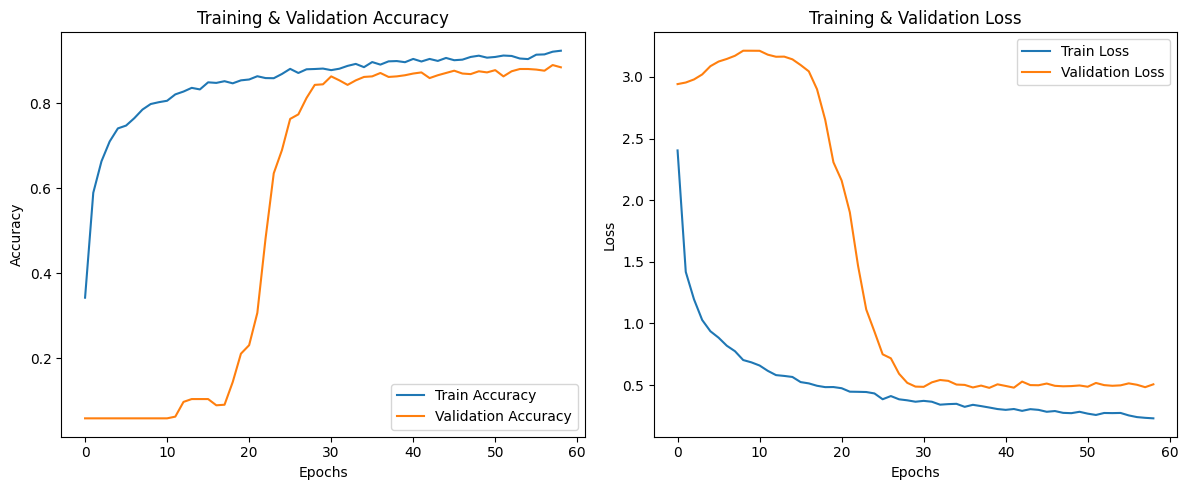

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


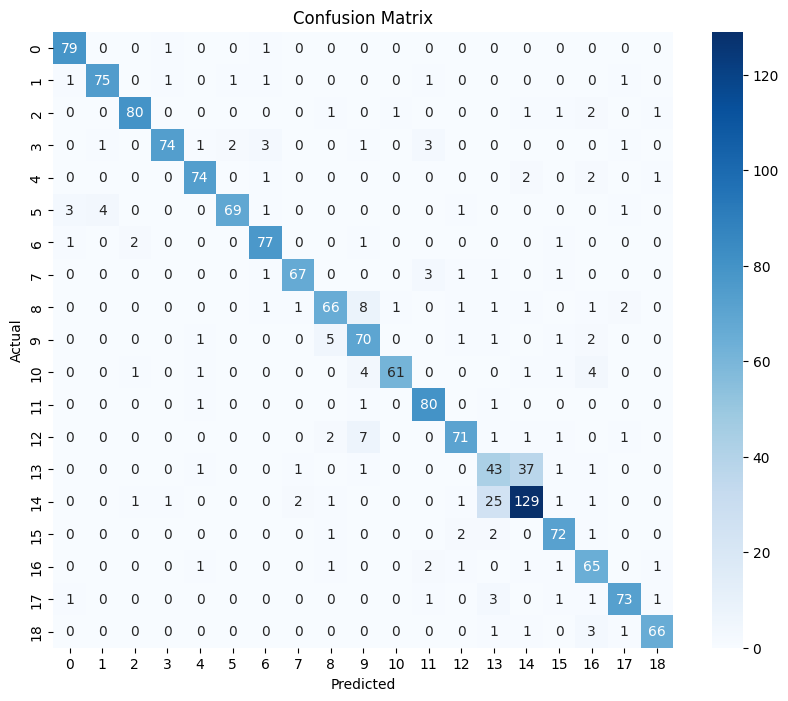

Precision (macro-average): 0.8774002865958918
Recall (macro-average): 0.8716707055819386
F1 Score (Macro-average): 0.8732374867347124


In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
import seaborn as sns

# Plot training history (accuracy and loss over epochs)
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.tight_layout()
plt.show()

# Generate predictions on the test set
y_pred = model.predict(X_test_flat)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class indices
y_test_classes = np.argmax(y_test, axis=1)  # True test labels

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

# Set axis labels for the confusion matrix
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')

print("Precision (macro-average):", precision)
print("Recall (macro-average):", recall)


f1 = f1_score(y_test_classes, y_pred_classes, average='macro')
print("F1 Score (Macro-average):", f1)

# Confusion Matrix and Training History

1. **Plotting Training History:**  
   - **Accuracy Plot:** The cell plots the training and validation accuracy over epochs. This helps visualize how well the model learns over time and whether it is overfitting or underfitting.
   - **Loss Plot:** Similarly, it plots the training and validation loss over epochs to monitor convergence.
   - Both plots use `plt.plot` on the `history.history` dictionary (generated during model training) and are arranged side by side using `plt.subplot` for a clear comparison.

2. **Generating and Visualizing the Confusion Matrix:**  
   - **Predictions:** The model generates predictions on the flattened test set. Since the model outputs probabilities (via softmax), `np.argmax` is used to convert these into discrete class indices.
   - **Confusion Matrix Calculation:** The confusion matrix is calculated using scikit-learn's `confusion_matrix` function, which compares the true class indices (`y_test_classes`) with the predicted indices (`y_pred_classes`).
   - **Visualization:** The confusion matrix is then plotted as a heatmap using Seaborn (`sns.heatmap`), with annotations to show the count of predictions for each true-predicted pair.

# Precision, Recall, F1-Score and Model Performance

## F1-Score
The F1-score is a performance metric used in classification tasks that combines two key aspects:

- **Precision:**  
  The ratio of true positive predictions to all positive predictions. It measures how many of the predicted positive cases were actually correct.

- **Recall:**  
  The ratio of true positive predictions to all actual positive cases. It measures how well the model identifies all relevant instances. The F1-score is the **harmonic mean** of precision and recall

This metric is particularly useful when we have imbalanced classes or when we need a balance between precision and recall.

An F1-score of approximately **0.86**, as our result turns up, suggests that the model achieves a strong balance between precision and recall. In practical terms:

- **High Precision:**  
  The model correctly identifies a high proportion of the predicted positive cases.

- **High Recall:**  
  The model successfully captures most of the actual positive cases.

For an OCR application on captcha images, each segmented character is classified into a certain category (e.g., a letter or digit). To compute precision and recall, for each character in the test set, we record the predicted class and the true class. Other definitions,

   - **True Positives (TP)**: Cases where the model correctly predicts the character.
   - **False Positives (FP)**: Cases where the model incorrectly predicts a character that is not present.
   - **False Negatives (FN)**: Cases where the model fails to predict a character that is present.

- **Macro-average**: Computes the metric independently for each class and then takes the average, treating all classes equally.
- **Micro-average**: Aggregates the contributions of all classes to compute the average metric.

## Interpretation
- High precision indicates that when the model predicts a character, it is usually correct.
- High recall indicates that the model successfully identifies most of the actual characters in the captchas.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step

--- Model Performance Metrics ---
Prediction Accuracy: 0.9000
Precision: 0.8182
Recall: 0.7955
F1-Score: 0.8052

--- Performance Analysis ---
--------------------------------



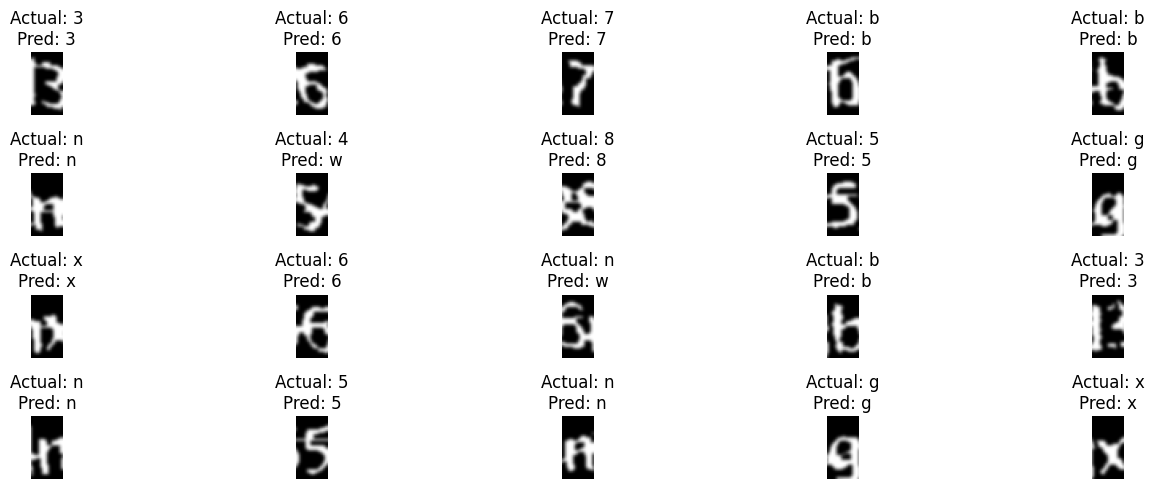

In [21]:
import random
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Randomly sample a subset of data for evaluation
sample_size = 20  # Number of test samples we want to visualize
random_indices = random.sample(range(len(X_test_flat)), sample_size)

X_test_sampled = X_test_flat[random_indices]
y_test_sampled = y_test[random_indices]

# Make predictions
predictions = model.predict(X_test_sampled)

# Decode predictions
predicted_labels = np.argmax(predictions, axis=1)
actual_labels = np.argmax(y_test_sampled, axis=1)

# Calculate Correctness Statistics with zero_division Fix
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, average="macro", zero_division=0)
recall = recall_score(actual_labels, predicted_labels, average="macro", zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, average="macro")

# Print Statistics
print(f"\n--- Model Performance Metrics ---")
print(f"Prediction Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}\n")

# Check for Overfitting and Underfitting
train_accuracy = history.history['accuracy'][-1]  # Last recorded training accuracy
val_accuracy = history.history['val_accuracy'][-1]  # Last recorded validation accuracy

print("--- Performance Analysis ---")

# Overfitting Alert
if train_accuracy - accuracy > 0.10:
    print("⚠️ Warning: Possible Overfitting! The model performs significantly better on training data than on test data.")

# Underfitting Alert
if train_accuracy < 0.70 and accuracy < 0.70:
    print("⚠️ Warning: Possible Underfitting! Both training and test accuracy are low. Model may need more training or better feature extraction.")

# Underperformance Alert
if accuracy - f1 > 0.10:
    print("⚠️ Warning: Possible Underperformance! The model's accuracy is high, but F1-score is lower, indicating misclassification issues.")

print("--------------------------------\n")

# Visualize the predictions
image_height = X.shape[1]
image_width = X.shape[2]

plt.figure(figsize=(15, 5))
for i in range(sample_size):
    plt.subplot(4, 5, i + 1)  # 4 rows x 5 columns grid for visualization
    plt.imshow(X_test_sampled[i].reshape(image_height, image_width), cmap='gray')  # Reshape dynamically
    plt.title(f"Actual: {label_encoder.inverse_transform([actual_labels[i]])[0]}\nPred: {label_encoder.inverse_transform([predicted_labels[i]])[0]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Demonstration Methodology for Testing the Model Against Random Segments

This cell illustrates how to evaluate the trained model on a randomly sampled subset of test segments and visually compare the model's predictions with the actual labels. Below is a detailed explanation of the demonstration process:

1. **Random Sampling of Test Data:**  
   - The code first randomly selects a subset of test examples from the flattened test dataset (`X_test_flat`) using Python’s `random.sample`.  
   - The variable `sample_size` (set to 10) determines how many test samples are chosen for visualization.
   - The corresponding one-hot encoded labels for these samples are extracted from `y_test`.

2. **Model Predictions:**  
   - The model’s `predict` method is applied to the sampled test data to obtain prediction probabilities.
   - `np.argmax` is then used on both the predictions and the one-hot encoded test labels to convert them into discrete class indices.

3. **Decoding Labels:**  
   - The predicted class indices and actual class indices are converted back to their original label representations using the previously fitted `label_encoder.inverse_transform` method. This step makes the output human-readable (e.g., "A", "B", "1", etc.).

4. **Visualization:**  
   - The sampled test images are reshaped back to their original dimensions (using `image_height` and `image_width`) for display.
   - A grid layout (4 rows by 5 columns) is used to plot the images, with each subplot showing:
     - The test image.
     - A title displaying the **Actual** label (from the ground truth) and the **Predicted** label (from the model).
   - Axes are turned off for a cleaner look.
   - Finally, `plt.tight_layout()` ensures the subplots are neatly arranged, and `plt.show()` renders the visualization.

This demonstration methodology provides a clear, visual insight into the model's performance on unseen data, allowing us to quickly assess areas where the model performs well or may need further improvement.
